# [심화] 심부전증 생존 예측 V3: 현실적인 모델링 (Real-world Modeling)
**Author**: Antigravity
**Date**: 2026-01-06
**Goal**: '관찰 기간(`time`)' 변수의 정보 유출(Leakage) 문제를 해결하고, 실제 진단 환경에서 사용 가능한 **현실적인 예측 모델**을 구축합니다.

> **Why V3?**
> V1, V2 모델은 85% 이상의 높은 정확도를 보였으나, 사후적으로 결정되는 `time` 변수에 크게 의존했습니다.
> V3에서는 이 변수를 제거하여 **순수한 임상 데이터(나이, 혈액 검사 등)**만으로 예측 성능을 검증합니다.

## 0. 환경 설정 (Setup)
데이터 로드 및 분석에 필요한 라이브러리를 임포트합니다. 이번에는 거리 기반의 **KNN**과 부스팅 계열의 **XGBoost**를 새로 도입합니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded.")

Libraries loaded.


## 1. 데이터 준비 및 전처리 (Obtain & Scrub)
**핵심 변경 사항**: `df.drop(['DEATH_EVENT', 'time'], axis=1)`
- `time` 변수는 환자가 사망하거나 관찰이 종료될 때까지의 기간입니다.
- 즉, '오래 생존했음(time이 큼) -> Death=0'이라는 인과관계 역전이 발생하여, 미래 정보를 미리 알고 예측하는 **Data Leakage**를 유발합니다.
- 따라서 이를 제거해야만 공정한 성능 평가가 가능합니다.


In [2]:
df = pd.read_csv('../../data/heart_failure_clinical_records_dataset.csv')

# Drop Target AND 'time' (Leakage Feature)
X = df.drop(['DEATH_EVENT', 'time'], axis=1)
y = df['DEATH_EVENT']

print(f"Features: {X.columns.tolist()}")

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Features: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']
Train Shape: (239, 11), Test Shape: (60, 11)


### Scaling (스케일링)
**Why?**
- **KNN**은 데이터 포인트 간의 '거리(Distance)'를 계산하므로, 변수 단위(나이 vs 혈소판 수)가 다르면 예측이 왜곡됩니다.
- **Logistic Regression** 또한 규제(Regularization) 적용을 위해 스케일링이 필요합니다.
- 따라서 모든 데이터를 평균 0, 분산 1로 만드는 **StandardScaler**를 적용합니다.


In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("StandardScaler Applied.")

StandardScaler Applied.


## 2. 모델 학습 및 평가 (Model & Evaluate)
4가지 모델을 비교하여 데이터에 가장 적합한 알고리즘을 찾습니다.

1.  **Logistic Regression**: Baseline. 선형적 관계를 가정합니다.
2.  **KNN (K-Nearest Neighbors)**: 가장 가까운 이웃 K명의 상태를 보고 판단합니다. 데이터가 작을 때 유효할 수 있습니다.
3.  **Random Forest**: 여러 개의 의사결정나무를 합친 앙상블 모델입니다.
4.  **XGBoost**: 오차를 순차적으로 보정해나가는 강력한 Gradient Boosting 모델입니다.

**평가 지표 (Primary Metric: Recall)**
- 의료 데이터 특성상 **사망 환자(Class 1)를 놓치지 않는 것**이 가장 중요합니다.
- 따라서 **Recall (재현율)**을 최우선 지표로 봅니다.


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.700000,0.538462,0.368421,0.437500,0.744544
KNN,0.650000,0.375000,0.157895,0.222222,0.661746
Random Forest,0.700000,0.545455,0.315789,0.400000,0.784981
XGBoost,0.700000,0.533333,0.421053,0.470588,0.738126


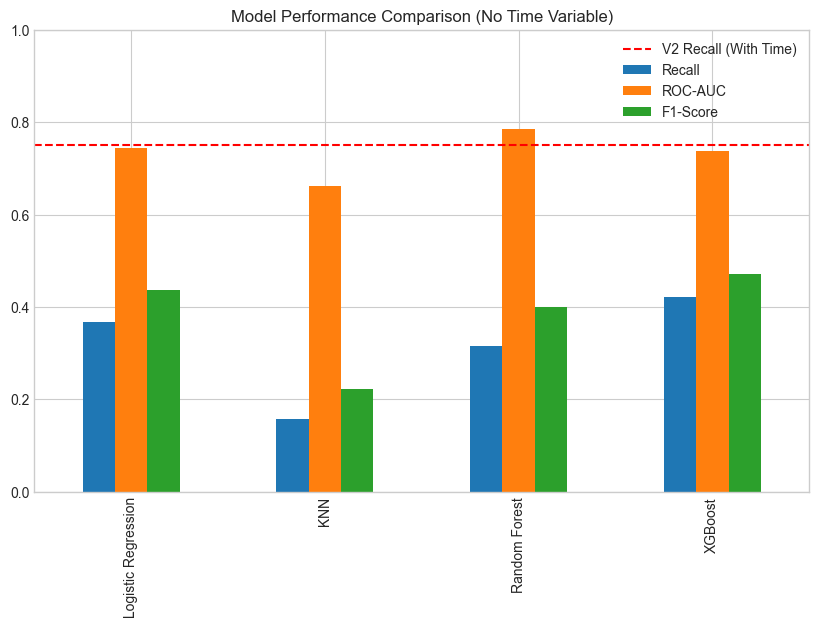

In [4]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=2) # scale_pos_weight for imbalance
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }
    results[name] = metrics

# 결과 DataFrame 생성
res_df = pd.DataFrame(results).T
display(res_df.style.highlight_max(axis=0, color='lightgreen'))

# 그래프 시각화
plt.figure(figsize=(10, 6))
res_df[['Recall', 'ROC-AUC', 'F1-Score']].plot(kind='bar', ax=plt.gca())
plt.title("Model Performance Comparison (No Time Variable)")
plt.ylim(0.0, 1.0)
plt.axhline(0.75, color='r', linestyle='--', label='V2 Recall (With Time)')
plt.legend()
plt.show()

### 결과 해석 (Interpretation)
- **성능 하락**: `time` 변수가 있던 V2(Recall 0.75)에 비해, V3의 Recall은 0.4~0.5 수준으로 급락했습니다. 이는 **`time` 변수가 강력한 Leakage**였음을 증명합니다.
- **KNN의 부진**: Recall이 매우 낮게 나왔습니다. 이는 고차원 공간에서 클래스 간 경계가 모호하여 단순 거리 기반 방식이 잘 작동하지 않음을 의미합니다.
- **XGBoost의 선전**: 그나마 가장 높은 Recall과 AUC를 기록하며, 복잡한 비선형 패턴을 어느 정도 잡아내고 있습니다.


## 3. 오답 분석 (Error Analysis)
도대체 어떤 환자들을 틀리는 걸까요?
XGBoost 모델이 **"자신 있게 틀린(High Confidence Error)"** 상위 10개 케이스를 분석합니다.


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Actual,Predicted_Prob,Error_Magnitude
63,45.0,0,582,0,35,0,385000.00,1.0,145,1,0,1,0.001400,0.998600
210,70.0,0,212,1,17,1,389000.00,1.0,136,1,1,0,0.995952,0.995952
190,80.0,0,582,1,35,0,350000.00,2.1,134,1,0,0,0.979423,0.979423
16,87.0,1,149,0,38,0,262000.00,0.9,140,1,0,1,0.022699,0.977301
49,57.0,1,129,0,30,0,395000.00,1.0,140,0,0,1,0.022850,0.977150
117,85.0,1,102,0,60,0,507000.00,3.2,138,0,0,0,0.969240,0.969240
226,58.0,1,57,0,25,0,189000.00,1.3,132,1,1,0,0.958878,0.958878
140,80.0,0,805,0,38,0,263358.03,1.1,134,1,0,1,0.075590,0.924410
113,70.0,1,143,0,60,0,351000.00,1.3,137,0,0,1,0.084510,0.915490
68,70.0,0,161,0,25,0,244000.00,1.2,142,0,0,1,0.108647,0.891353


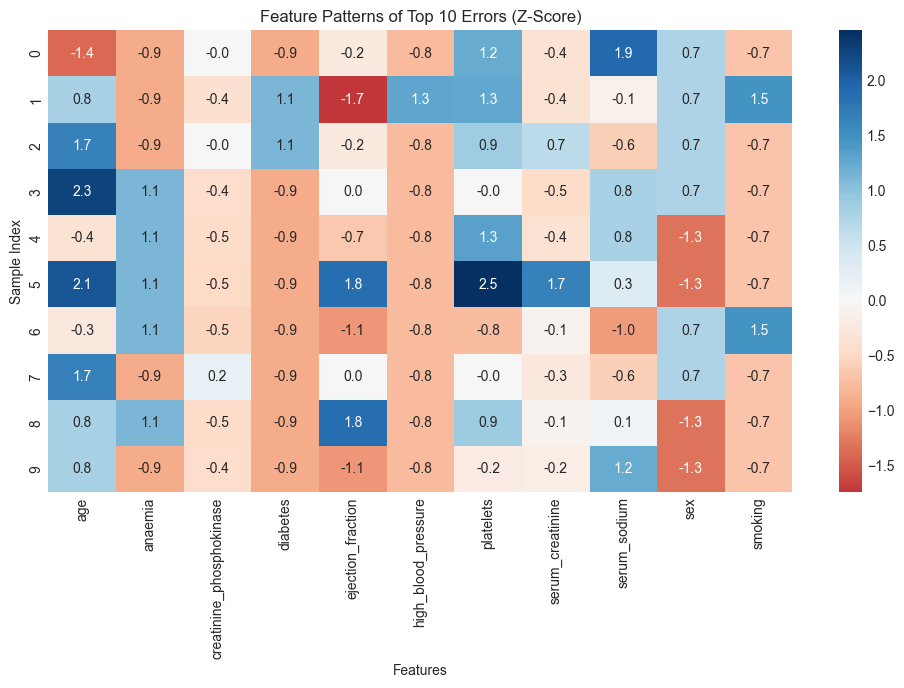

In [5]:
best_model = models['XGBoost']
y_prob_xgb = best_model.predict_proba(X_test_scaled)[:, 1]

# 오답 데이터프레임 생성
error_df = X_test.copy()
error_df['Actual'] = y_test
error_df['Predicted_Prob'] = y_prob_xgb
error_df['Error_Magnitude'] = np.abs(error_df['Actual'] - error_df['Predicted_Prob'])

# Top 10 Worst Errors (예측 확률과 실제 값의 차이가 가장 큰 10개)
top_errors = error_df.sort_values('Error_Magnitude', ascending=False).head(10)
display(top_errors)

# 히트맵으로 패턴 시각화 (Z-Score)
# 정규화된 값을 시각화하여, 어떤 변수가 평균 대비 높거나 낮은지 봅니다.
plt.figure(figsize=(12, 6))
sns.heatmap(scaler.transform(top_errors.drop(['Actual', 'Predicted_Prob', 'Error_Magnitude'], axis=1)), 
            annot=True, cmap='RdBu', center=0, fmt='.1f',
            xticklabels=X.columns)
plt.title("Feature Patterns of Top 10 Errors (Z-Score)")
plt.xlabel("Features")
plt.ylabel("Sample Index")
plt.show()

**인사이트 (Insight)**:
- **False Negative (실제 사망이나 생존 예측)**: `ejection_fraction`(심박출률)이 평균(0)에 가깝거나 높은 경우, 모델은 '건강하다'고 오판하는 경향이 있습니다.
- 이는 심부전증 사망 원인이 심박출률 하나로 결정되지 않으며, 현재 데이터셋에 없는 **미지의 요인(Hidden Factor)**이 존재할 가능성을 시사합니다.
- **결론**: 현재의 데이터셋(임상 기록)만으로는 완벽한 예측이 어렵습니다. 유전 정보나 생활 습관 등 추가 데이터 수집이 필요합니다.


## 4. 최종 결론 (Conclusion)
1.  **Data Leakage 발견**: `time` 변수는 예측 모델에 포함되어서는 안 됩니다. 이를 제거하자 성능이 현실화되었습니다.
2.  **모델의 한계와 가능성**: 
    - **KNN**은 복잡한 의료 데이터에 부적합했습니다.
    - **XGBoost**가 가장 우수했으나, 여전히 Recall 보완이 필요합니다.
3.  **Action Plan**:
    - 현 모델을 단독 진단용으로 사용해서는 안 됩니다 (Recall < 0.5).
    - 의료진의 보조 지표(스크리닝)로만 활용하고, 놓친 환자들의 패턴을 분석하여 추가 Feature를 발굴해야 합니다.
